# RANDOM FORESTS FOR IMAGE APPROXIMATION

##3a. Start with an image of the Mona Lisa

We choose this [image](http://tinyurl.com/mona-lisa-small).

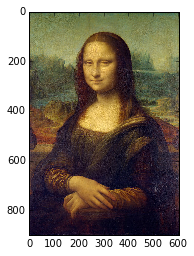

In [1]:
%matplotlib inline

from IPython.display import Image
filename='./Mona_Lisa,_by_Leonardo_da_Vinci,_from_C2RMF_retouched.jpg'
from skimage import io
io.use_plugin('matplotlib')

mona = io.imread(filename)
io.imshow(mona)

## 3b Preprocessing the input

In [2]:
import numpy as np
np.random.seed(1234)

def gen_random_index(data, sample = 5000):
    total = data.shape[0] * data.shape[1]
    indexes = np.random.choice(total, sample, replace=False)
    
    train = [[index / data.shape[1], index % data.shape[1]] for index in indexes]
    #other = [[index / data.shape[1], index % data.shape[1]] for index in range(total) if index not in indexes]
    
    return train

Train_points = gen_random_index(mona)
print len(Train_points)

5000


One of the benefits of decision trees is that ordinal (continuous or discrete) input data does not require any significant preprocessing, because decision trees do not require each dimension is measured in same unit. So we do not need to perform mean subtraction, standardization, or unit-normalization.

#3c Preprocessing the output

We will train three different models for each r,g,b channel.

##3d Rescale

In [3]:
def scale(data):
    res = np.empty_like(data.astype(float))
    res[:] = data
    
    for index in range(3):
        #print res[:,:,index] / 255.0
        res[:,:,index] = res[:,:,index] / 255.0
        
    return res

def scale_back(data):
    res = np.empty_like(data)
    res[:] = data
    
    for index in range(3):
        res[:,:,index] = res[:,:,index] * 255.0
    
    return res.astype('uint8')

mona_scaled = scale(mona)

## 3e Other preprocessing methods

In [4]:
def showPic(labels):
    labels = scale_back(labels)
    io.imshow(labels)
    io.show()

## 3f Random Forest implementations

We are using [scikit-learn random forest methods](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).


In [6]:
from sklearn.ensemble import RandomForestRegressor

Train = np.array(Train_points)
Labels = [mona_scaled[point[0], point[1], :] for point in Train_points]
Points = np.array([[point / mona.shape[1], point % mona.shape[1]] 
          for point in range(mona.shape[0] * mona.shape[1])])

def trainRF(depth, num_trees):
    def train_single(index):
        rf = RandomForestRegressor(n_estimators=num_trees, max_depth=depth)
        curr_labels = [opt[index] for opt in Labels]
        rf.fit(Train, curr_labels)
        return rf

    rf_cls = [train_single(index) for index in range(3)]
    
    res = np.empty_like(mona.astype(float))
    
    
    for index in range(3):
        output = rf_cls[index].predict(Points)
        output = output.reshape((mona.shape[0], mona.shape[1]))
        #print output.shape, res.shape
        res[:,:,index] = output
    
    
    print "num of trees is: " + str(num_trees)
    print "tree depth is: " + str(depth)

    print "Picture is :"
    showPic(res)


## 3g. Experimentation

###a depth

num of trees is: 1
tree depth is: 1
Picture is :


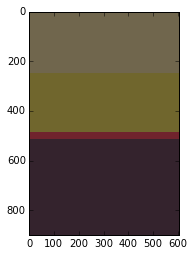

In [7]:
trainRF(1,1)

num of trees is: 1
tree depth is: 2
Picture is :


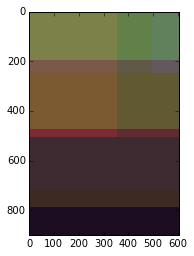

In [8]:
trainRF(2, 1)

num of trees is: 1
tree depth is: 3
Picture is :


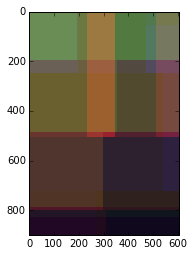

In [9]:
trainRF(3, 1)

num of trees is: 1
tree depth is: 5
Picture is :


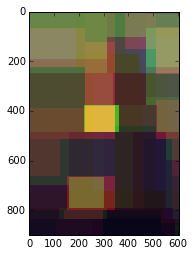

In [10]:
trainRF(5, 1)

num of trees is: 1
tree depth is: 10
Picture is :


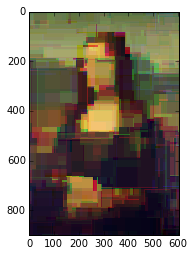

In [11]:
trainRF(10, 1)

num of trees is: 1
tree depth is: 15
Picture is :


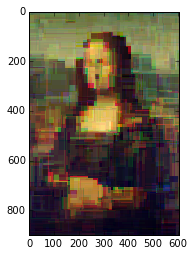

In [12]:
trainRF(15, 1)

As depth increases, the picture becomes more precise because the tree with more depth can learn more features and learn in finer grain, thus lead to better results.

### b num of trees

num of trees is: 1
tree depth is: 7
Picture is :


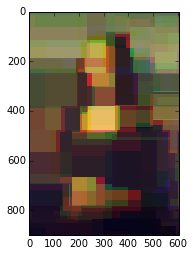

In [13]:
trainRF(7, 1)

num of trees is: 3
tree depth is: 7
Picture is :


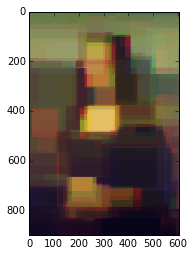

In [14]:
trainRF(7, 3)

num of trees is: 5
tree depth is: 7
Picture is :


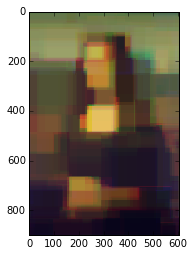

In [15]:
trainRF(7, 5)

num of trees is: 10
tree depth is: 7
Picture is :


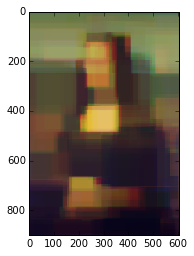

In [16]:
trainRF(7, 10)

num of trees is: 100
tree depth is: 7
Picture is :


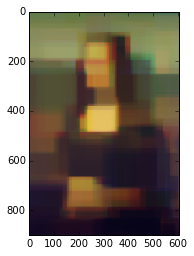

In [17]:
trainRF(7, 100)

More the num of trees, better the result is. The reason is that the number of observations is large and small number of trees can not capture all the features and might miss some important features. However, once the number of trees is large enough, increasing the number of trees will not increase the performance anymore.

## c k-NN regressor

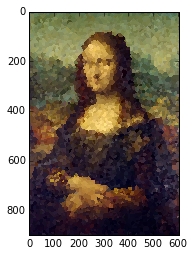

In [18]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1)

knn.fit(Train, Labels)
Predict = knn.predict(Points).reshape((mona.shape[0], mona.shape[1], 3))
showPic(Predict)

The knn regressor result is shown above, comparing with original mona pic shows that it keeps the figure but blurs the edges because the missing parts are learned from the nearest neighbors, so colors in edge areas are "averaged" and lacks precision.

### d pruning strategies

We do not do any prune of trees, because although single decison tree might overfit, picking random features and training samples will prevent overfitting.

## 3h Analysis

### a

The decision rule at each split point is like x > N or y < M where N, M are certain thresholds. For random forest regressor, the formula is to find least mean squared error, $$N = \underset{x}{argmin}\text{ }mean({x_{predicted} - x_{actual}})^2$$

### b

The resulting image will consist of different color patches, the split is a line in the picture, so the shapes are all rectangles, they are arranged according to the split linee, e.g (x < 50 and y > 30) -> blue.

### c

There will be 2^k patches, because there are 2^k leaf nodes.

### d

Because there are n trees, there are n * 2^k leaf nodes, but they may predict on overlapping regions, so the patches are smaller than n * 2^k